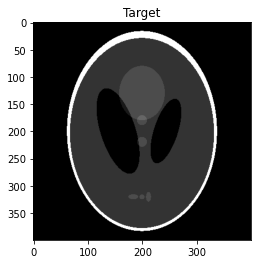

In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import scipy.interpolate
import scipy.fftpack
import scipy.misc
import scipy.ndimage.interpolation
from skimage.data import shepp_logan_phantom
image = shepp_logan_phantom()

S=400 # Size of target, and resolution of Fourier space
N=2001 # Number of sinogram exposures (odd number avoids redundant direct opposites)

V=100 # Range on fft plots

# Convenience function
def sqr(x): return x*x

# Return the angle of the i-th (of 0-to-N-1) sinogram exposure in radians.
def angle(i): return (math.pi*i)/N

# Prepare a target image
x,y=np.meshgrid(np.arange(S)-S/2,np.arange(S)-S/2)
mask=(sqr(x)+sqr(y)<=sqr(S/2-10))
target=image

plt.figure()
plt.title("Target")
plt.imshow(target)
plt.gray()



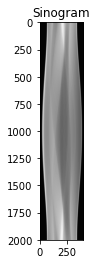

In [2]:
# Project the sinogram (ie calculate Radon transform)
sinogram=np.array([
        np.sum(
            scipy.ndimage.interpolation.rotate(
                target,
                np.rad2deg(angle(i)), # NB rotate takes degrees argument
                order=3,
                reshape=False,
                mode='constant',
                cval=0.0
                )
            ,axis=0
            ) for i in range(N)
        ])

plt.figure()
plt.title("Sinogram")
plt.imshow(sinogram)
plt.gray()



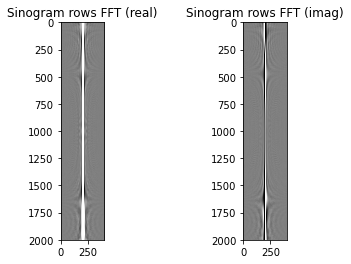

In [3]:
# Fourier transform the rows of the sinogram, move the DC component to the row's centre
sinogram_fft_rows=scipy.fftpack.fftshift(
    scipy.fftpack.fft(
        scipy.fftpack.ifftshift(
            sinogram,
            axes=1
            )
        ),
    axes=1
    )

plt.figure()
plt.subplot(121)
plt.title("Sinogram rows FFT (real)")
plt.imshow(np.real(sinogram_fft_rows),vmin=-V,vmax=V)
plt.subplot(122)
plt.title("Sinogram rows FFT (imag)")
plt.imshow(np.imag(sinogram_fft_rows),vmin=-V,vmax=V)



(-19.999741181820568,
 419.9999876753248,
 -18.949932537798666,
 419.9499322296817)

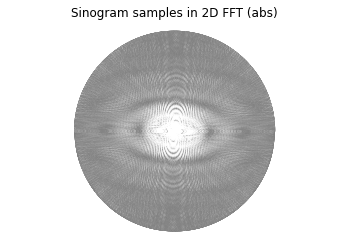

In [4]:
# Coordinates of sinogram FFT-ed rows' samples in 2D FFT space
a=np.array([angle(i) for i in range(N)])
r=np.arange(S)-S/2+1
r,a=np.meshgrid(r,a)
r=r.flatten()
a=a.flatten()
srcx=(S/2)+r*np.cos(a)
srcy=(S/2)+r*np.sin(a)

# Coordinates of regular grid in 2D FFT space
dstx,dsty=np.meshgrid(np.arange(S),np.arange(S))
dstx=dstx.flatten()
dsty=dsty.flatten()

plt.figure()
plt.title("Sinogram samples in 2D FFT (abs)")
plt.scatter(
    srcx,
    srcy,
    c=np.absolute(sinogram_fft_rows.flatten()),
    marker='.',
    edgecolor='none',
    vmin=-V,
    vmax=V
    )
plt.axis("equal")
plt.axis("off")



(-19.999741181820568,
 419.9999876753248,
 -18.949932537798666,
 419.9499322296817)

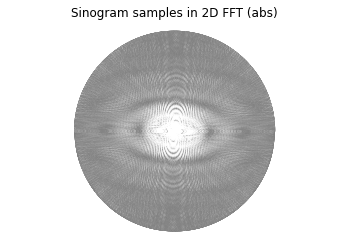

In [5]:
# Coordinates of sinogram FFT-ed rows' samples in 2D FFT space
a=np.array([angle(i) for i in range(N)])
r=np.arange(S)-S/2+1
r,a=np.meshgrid(r,a)
r=r.flatten()
a=a.flatten()
srcx=(S/2)+r*np.cos(a)
srcy=(S/2)+r*np.sin(a)

# Coordinates of regular grid in 2D FFT space
dstx,dsty=np.meshgrid(np.arange(S),np.arange(S))
dstx=dstx.flatten()
dsty=dsty.flatten()

plt.figure()
plt.title("Sinogram samples in 2D FFT (abs)")
plt.scatter(
    srcx,
    srcy,
    c=np.absolute(sinogram_fft_rows.flatten()),
    marker='.',
    edgecolor='none',
    vmin=-V,
    vmax=V
    )
plt.axis("equal")
plt.axis("off")

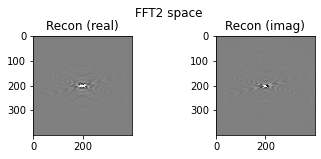

In [6]:
# Let the central slice theorem work its magic!
# Interpolate the 2D Fourier space grid from the transformed sinogram rows
fft2=scipy.interpolate.griddata(
    (srcy,srcx),
    sinogram_fft_rows.flatten(),
    (dsty,dstx),
    method='cubic',
    fill_value=0.0
    ).reshape((S,S))

plt.figure()
plt.suptitle("FFT2 space")
plt.subplot(221)
plt.title("Recon (real)")
plt.imshow(np.real(fft2),vmin=-V,vmax=V)
plt.subplot(222)
plt.title("Recon (imag)")
plt.imshow(np.imag(fft2),vmin=-V,vmax=V)



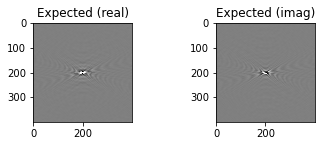

In [7]:
# Show 2D FFT of target, just for comparison
expected_fft2=scipy.fftpack.fftshift(
    scipy.fftpack.fft2(
        scipy.fftpack.ifftshift(
            target
            )
        )
    )

plt.subplot(223)
plt.title("Expected (real)")
plt.imshow(np.real(expected_fft2),vmin=-V,vmax=V)
plt.subplot(224)
plt.title("Expected (imag)")
plt.imshow(np.imag(expected_fft2),vmin=-V,vmax=V)



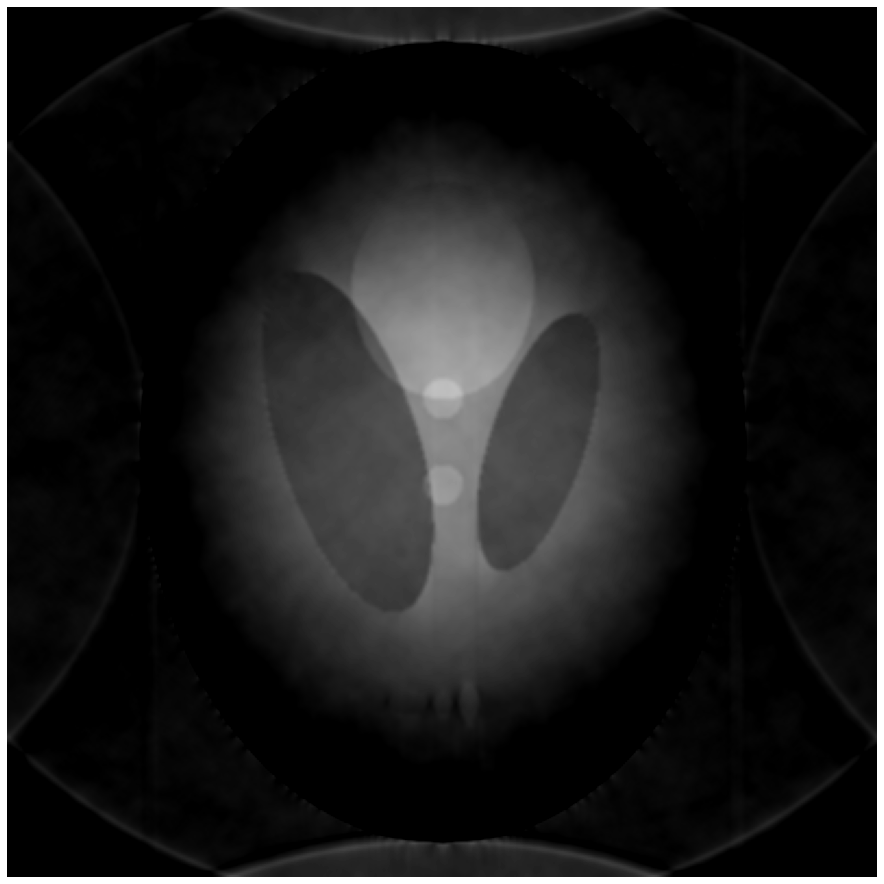

In [17]:
from skimage.filters import window


# Transform from 2D Fourier space back to a reconstruction of the target
recon=np.real(
    scipy.fftpack.fftshift(
        scipy.fftpack.ifft2(
            scipy.fftpack.ifftshift(fft2* window('hann', (S,S)))
            )
        )
    )

plt.figure(figsize=(16,16))
#plt.title("Reconstruction")
plt.imshow(recon,vmin=0.0,vmax=1.0)
plt.gray()
plt.axis("off")

plt.savefig("reconstruction.png")



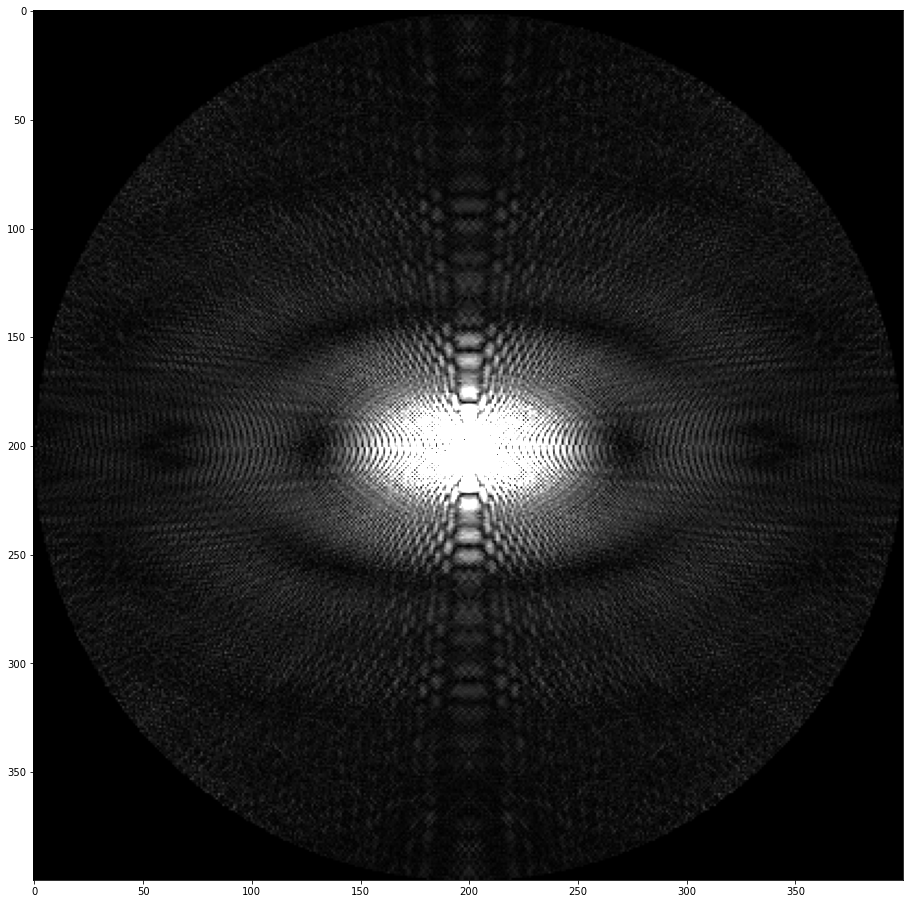

In [9]:
plt.figure(figsize=(16,16))
plt.imshow(abs(fft2), cmap="gray", vmin=0, vmax=200)

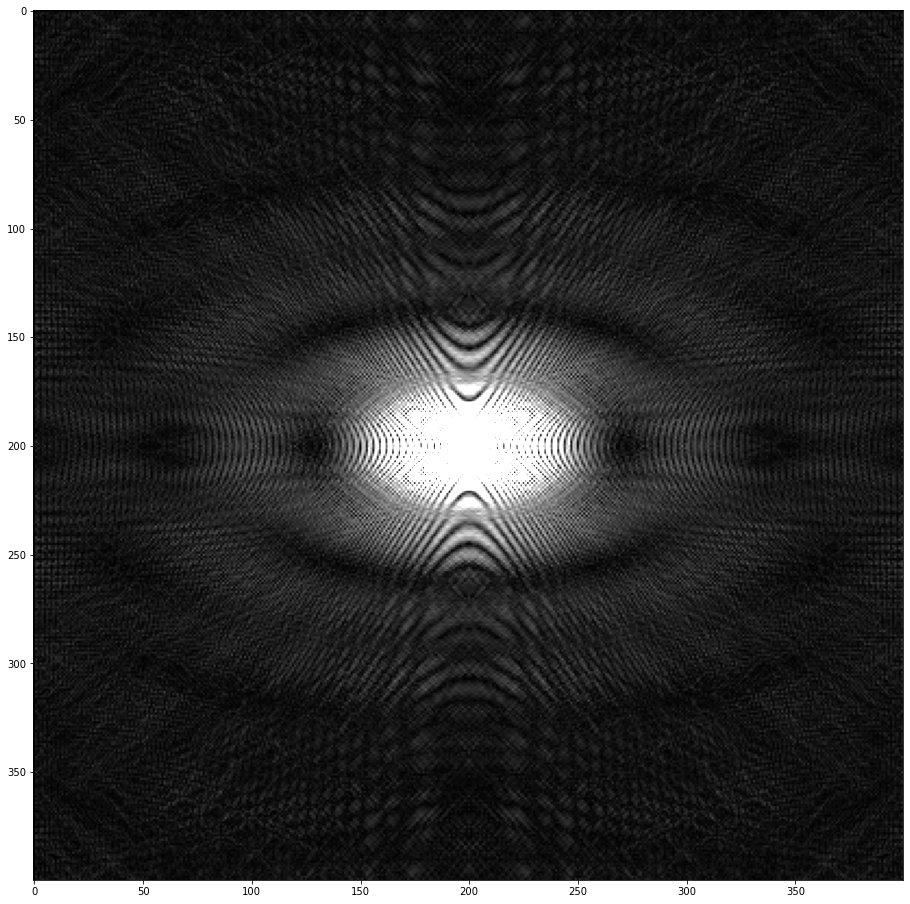

In [10]:
plt.figure(figsize=(16,16))
plt.imshow(abs(expected_fft2), cmap="gray", vmin=0, vmax=200)

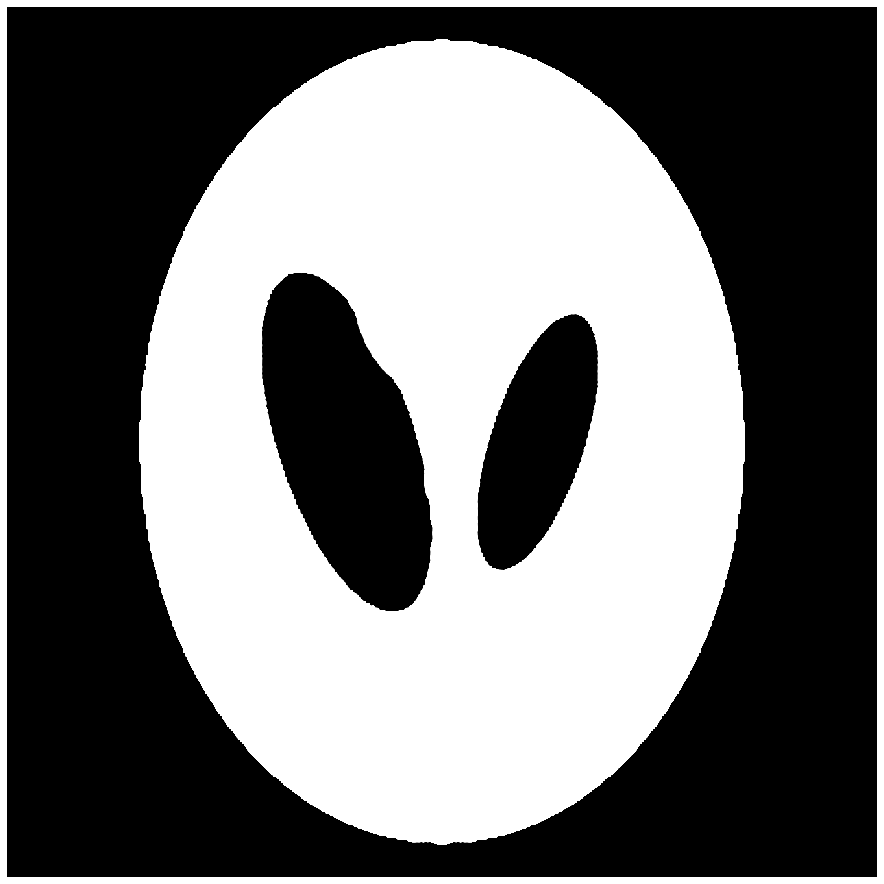

In [14]:
from skimage.transform import resize, rotate, iradon_sart, radon
def FilteredBackProjection(sinogram):
    #reconstruction = iradon(sinogram, theta, filter='hamming', circle=False) 
    N = sinogram.shape[1]
    theta = np.linspace(0,180, sinogram.shape[0], endpoint=False)
    omega = np.array(range(0,np.floor_divide(N,2)))
    omega = np.append(omega, range(-np.floor_divide(N,2),0))
    c = 0.1
    W = c + (1-c) * np.cos(2*np.pi*omega/(N-1))
    reconstruction = np.zeros((N,N))
    for i in range(0, len(theta)):
        FT = np.fft.fft(sinogram[i])
        g = np.real(np.fft.ifft([W_i * np.abs(omega_i) * FT_i for W_i, omega_i, FT_i in zip(W, omega, FT) ]))
        reconstruction +=rotate(np.ones((N,1)) * g, -theta[i])
    reconstruction /=len(theta)
    return reconstruction

recon = FilteredBackProjection(sinogram)



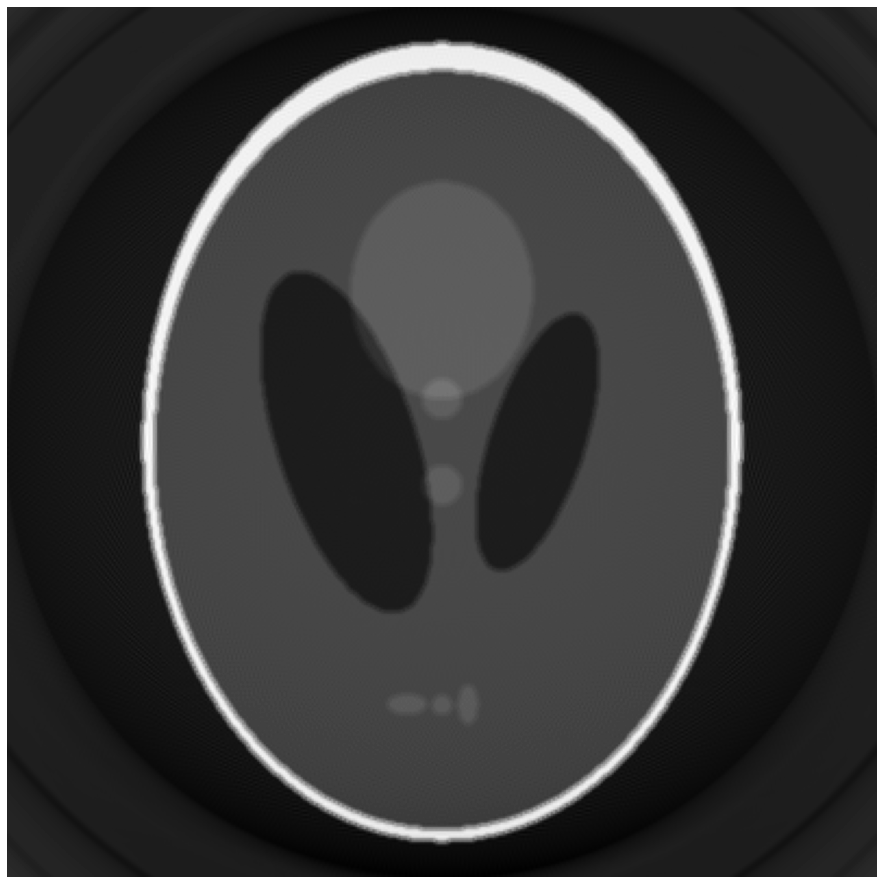

In [15]:
plt.figure(figsize=(16,16))
#plt.title("Reconstruction")
plt.imshow(recon)
plt.gray()
plt.axis("off")

plt.savefig("reconstruction.png")